# Exercise 10
## Lars Kühmichel, Nicolas Wolf

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

In [3]:
device = torch.device("cpu")

## Task 1: Backpropagation Through Time Spoiler

...

## Task 2: The influence of noise on the data

### Find a number of hidden units where the RNN clearly overfits the data.

Through trial-and-error we found that a sub-sequence length of 6 and a 10k-dimensional latent space reliably achieved significant overfit.

In [4]:
sinus = torch.load("noisy_sinus.pt")

sinus.shape

torch.Size([41, 2])

In [5]:
class LatentRNN(nn.Module):
    def __init__(self, obs_dim, latent_dim, dropout=0):
        super().__init__()
        self.RNN = nn.RNN(obs_dim, latent_dim, dropout=dropout, num_layers=1, nonlinearity='relu')
        self.observation_model = nn.Linear(latent_dim, obs_dim)

    def forward(self, time_series, h0):
        # The RNN class doesn't care how long the input is as long as time is the first and features the last dim
        rnn_output, h = self.RNN(time_series, h0)
        obs_output = self.observation_model(rnn_output)
        return obs_output, h

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data: torch.Tensor, sub_size: int):
        """
        Time Series Dataset that yields time-contiguous batches of a predetermined sub-size
        :param data: the time series data
        :param sub_size: the size of drawn sub-sequences
        """
        super().__init__()
        self.data = data
        self.sub_size = sub_size

    def __getitem__(self, item):
        return self.data[item:item + self.sub_size]

    def __len__(self):
        return len(self.data) - self.sub_size + 1

In [7]:
obs_dim = sinus.shape[1]
latent_dim = 100  # hyperparameter
sub_size = 16
batch_size = 4
learning_rate = 1e-3

rnn = LatentRNN(obs_dim, latent_dim).to(device)

In [8]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# conditioning an LR Scheduler on the train loss really helped achieve overfit
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[100, 200],
    gamma=0.1,
)
criterion = nn.MSELoss()
epochs = 300
dataset = TimeSeriesDataset(sinus, sub_size=sub_size)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=16,
)

In [9]:
def train_rnn(model, optimizer, criterion, epochs, train_loader, lr_scheduler=None, val_loader=None):
    train_loss = []
    val_loss = []

    for _ in tqdm(range(epochs)):
        train_loss_this_epoch = []

        model.train()
        for batch in train_loader:
            x = batch[:, :-1, ...].to(device)
            y = batch[:, 1:, ...].to(device)
            h0 = torch.randn((1, batch.shape[1] - 1, latent_dim)).to(device)

            optimizer.zero_grad()

            yhat, h = model.forward(x, h0)

            loss = criterion(yhat, y)

            train_loss_this_epoch.append(float(loss.detach().cpu()))

            loss.backward()
            optimizer.step()

        loss = np.mean(train_loss_this_epoch)
        train_loss.append(loss)

        if lr_scheduler is not None:
            lr_scheduler.step()

        if val_loader is not None:
            with torch.no_grad():
                val_loss_this_epoch = []

                model.eval()
                for batch in val_loader:
                    x = batch[:, :-1, ...].to(device)
                    y = batch[:, 1:, ...].to(device)
                    h0 = torch.randn((1, batch.shape[1] - 1, latent_dim)).to(device)

                    yhat, h = model.forward(x, h0)

                    loss = criterion(yhat, y)

                    val_loss_this_epoch.append(float(loss.detach().cpu()))
                loss = np.mean(val_loss_this_epoch)
                val_loss.append(loss)

    return train_loss, val_loss

In [10]:
train_loss, _ = train_rnn(rnn, optimizer, criterion, epochs, dataloader, lr_scheduler)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

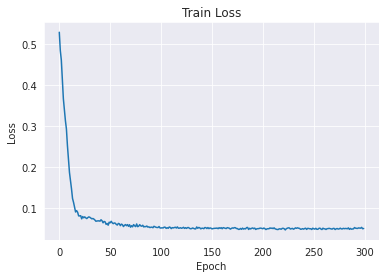

In [11]:
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

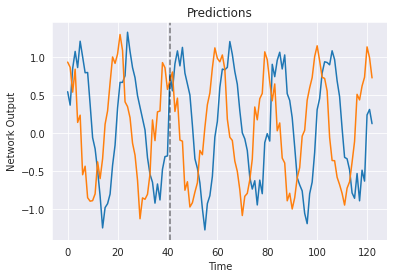

In [12]:
with torch.no_grad():
    rnn.eval()
    # get some predictions
    p0, h0 = sinus.to(device), torch.randn(sinus.shape[1] - 1, latent_dim).to(device)
    p1, h1 = rnn.forward(p0, h0=h0)
    p2, h2 = rnn.forward(p1, h0=h1)

    p = torch.cat((p0, p1, p2)).cpu().numpy()
    h = torch.cat((h0, h1, h2)).cpu().numpy()

plt.plot(p)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Network Output")
plt.axvline(len(sinus), ls="--", color="black", alpha=0.5)

### 1. Apply L1 Regularization.

In [13]:
class L1Regularizer(nn.Module):
    def __init__(self, parameters, criterion, alpha=0.1):
        super().__init__()
        self.model_parameters = parameters
        self.criterion = criterion
        self.alpha = alpha

    def forward(self, yhat, y):
        return self.criterion(yhat, y) + self.alpha * sum([torch.sum(torch.abs(p)) for p in self.model_parameters])

In [14]:
obs_dim = sinus.shape[1]
latent_dim = 100  # hyperparameter
sub_size = 16
batch_size = 4
learning_rate = 1e-3

rnn = LatentRNN(obs_dim, latent_dim).to(device)

In [15]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# conditioning an LR Scheduler on the train loss really helped achieve overfit
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[100, 200],
    gamma=0.1,
)
criterion = L1Regularizer(rnn.parameters(), nn.MSELoss())
epochs = 300
dataset = TimeSeriesDataset(sinus, sub_size=sub_size)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=16,
)

In [16]:
train_loss, _ = train_rnn(rnn, optimizer, criterion, epochs, dataloader, lr_scheduler)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

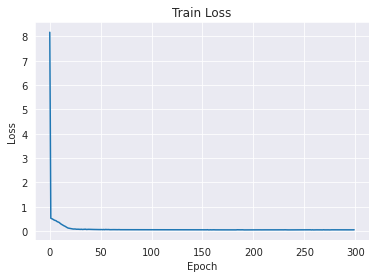

In [17]:
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

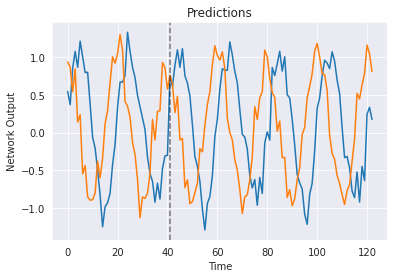

In [18]:
with torch.no_grad():
    rnn.eval()
    # get some predictions
    p0, h0 = sinus.to(device), torch.randn(sinus.shape[1] - 1, latent_dim).to(device)
    p1, h1 = rnn.forward(p0, h0=h0)
    p2, h2 = rnn.forward(p1, h0=h1)

    p = torch.cat((p0, p1, p2)).cpu().numpy()
    h = torch.cat((h0, h1, h2)).cpu().numpy()

plt.plot(p)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Network Output")
plt.axvline(len(sinus), ls="--", color="black", alpha=0.5)

### 2. Add L2 Regularization

In [19]:
obs_dim = sinus.shape[1]
latent_dim = 100  # hyperparameter
sub_size = 16
batch_size = 4
learning_rate = 1e-3

rnn = LatentRNN(obs_dim, latent_dim).to(device)

In [20]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=0.1)

# conditioning an LR Scheduler on the train loss really helped achieve overfit
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[100, 200],
    gamma=0.1,
)
criterion = nn.MSELoss()
epochs = 300
dataset = TimeSeriesDataset(sinus, sub_size=sub_size)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=16,
)

In [21]:
train_loss, _ = train_rnn(rnn, optimizer, criterion, epochs, dataloader, lr_scheduler)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

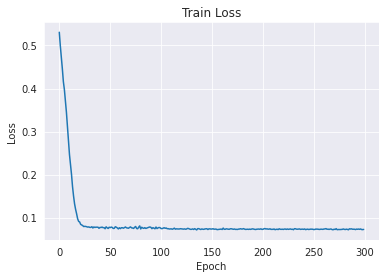

In [22]:
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

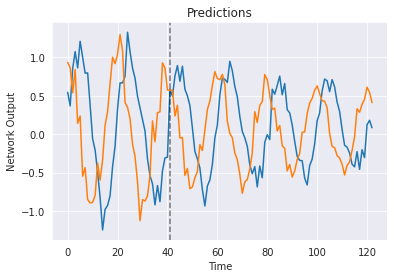

In [23]:
with torch.no_grad():
    rnn.eval()
    # get some predictions
    p0, h0 = sinus.to(device), torch.randn(sinus.shape[1] - 1, latent_dim).to(device)
    p1, h1 = rnn.forward(p0, h0=h0)
    p2, h2 = rnn.forward(p1, h0=h1)

    p = torch.cat((p0, p1, p2)).cpu().numpy()
    h = torch.cat((h0, h1, h2)).cpu().numpy()

plt.plot(p)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Network Output")
plt.axvline(len(sinus), ls="--", color="black", alpha=0.5)

### 3. Apply Dropout

In [24]:
obs_dim = sinus.shape[1]
latent_dim = 100  # hyperparameter
sub_size = 16
batch_size = 4
learning_rate = 1e-3

rnn = LatentRNN(obs_dim, latent_dim, dropout=0.5).to(device)

/home/lars/code/python/TSA-RNN/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [25]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# conditioning an LR Scheduler on the train loss really helped achieve overfit
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[100, 200],
    gamma=0.1,
)
criterion = nn.MSELoss()
epochs = 300
dataset = TimeSeriesDataset(sinus, sub_size=sub_size)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=16,
)

In [26]:
train_loss, _ = train_rnn(rnn, optimizer, criterion, epochs, dataloader, lr_scheduler)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

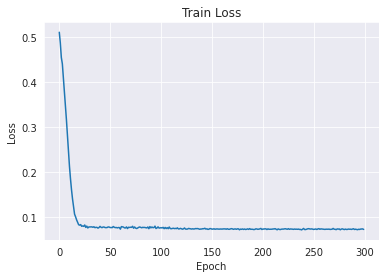

In [27]:
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

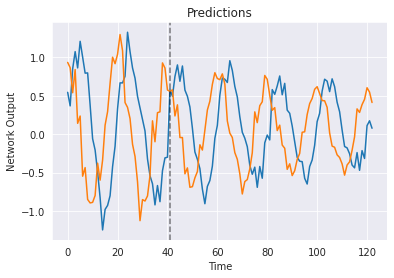

In [28]:
with torch.no_grad():
    rnn.eval()
    # get some predictions
    p0, h0 = sinus.to(device), torch.randn(sinus.shape[1] - 1, latent_dim).to(device)
    p1, h1 = rnn.forward(p0, h0=h0)
    p2, h2 = rnn.forward(p1, h0=h1)

    p = torch.cat((p0, p1, p2)).cpu().numpy()
    h = torch.cat((h0, h1, h2)).cpu().numpy()

plt.plot(p)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Network Output")
plt.axvline(len(sinus), ls="--", color="black", alpha=0.5)

### Find arguments (briefly) why each of the techniques counteract overfitting:

#### L1 Regularization:
Punishes large weights, thus reducing network dependency on single neurons. This means the network is forced to use more of its capacity.

#### L2 Regularization:
Same reason as above.

#### Dropout:
Same reason as above, since neurons with large weights have a random chance to be turned off. Additionally:

1. Dropout increases network robustness since we effectively train many sub-networks (similar to a random forest). When dropout is turned off, we effectively take the mean of the sub-networks.
2. Dropout reduces neuron co-dependency, disallowing the network to counteract a bad activation in one neuron with another bad activation in another.